In [23]:
import torch
from torch import nn
from pandas import DataFrame
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

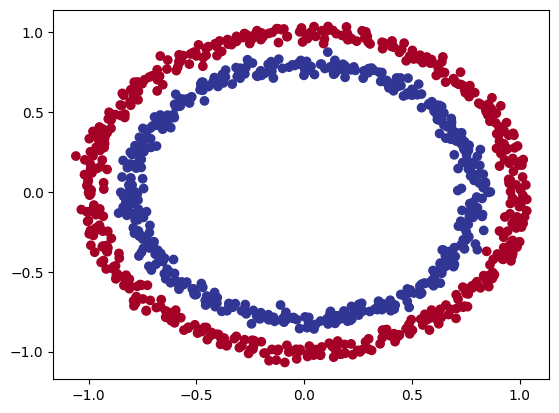

In [24]:
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Make and plot data
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

# Split using NumPy arrays
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors and move to CUDA
X_train = torch.from_numpy(X_train_np).float().to("cuda")
X_test = torch.from_numpy(X_test_np).float().to("cuda")
y_train = torch.from_numpy(y_train_np).float().to("cuda")
y_test = torch.from_numpy(y_test_np).float().to("cuda")

In [25]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        # non linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # where should we put our non linear activation function
        # x -> layer_1 -> relu -> layer_2 -> relu -> layer_3
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device="cuda")

model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [26]:
loss_fn = nn.BCEWithLogitsLoss()

optimzer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)



In [27]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [29]:
epochs = 2000

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    
    optimzer.zero_grad()
    
    loss.backward()
    
    optimzer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_loss = loss_fn(y_test, test_logits)
        test_logits_preds = torch.round(torch.sigmoid(test_logits))
        test_preds = accuracy_fn(y_true=y_test, y_pred=test_logits_preds)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {acc:.2f}% | Test acc: {test_preds:.2f}%")

Epoch: 0 | Train loss: 0.69295 | Test loss: 0.99243 | Train acc: 50.00% | Test acc: 50.00%
Epoch: 10 | Train loss: 0.69248 | Test loss: 0.99507 | Train acc: 50.50% | Test acc: 50.00%
Epoch: 20 | Train loss: 0.69225 | Test loss: 0.99743 | Train acc: 59.13% | Test acc: 56.50%
Epoch: 30 | Train loss: 0.69209 | Test loss: 0.99921 | Train acc: 70.25% | Test acc: 68.00%
Epoch: 40 | Train loss: 0.69195 | Test loss: 1.00051 | Train acc: 68.38% | Test acc: 71.00%
Epoch: 50 | Train loss: 0.69181 | Test loss: 1.00146 | Train acc: 58.25% | Test acc: 58.00%
Epoch: 60 | Train loss: 0.69168 | Test loss: 1.00221 | Train acc: 54.00% | Test acc: 54.50%
Epoch: 70 | Train loss: 0.69155 | Test loss: 1.00280 | Train acc: 53.12% | Test acc: 53.00%
Epoch: 80 | Train loss: 0.69141 | Test loss: 1.00321 | Train acc: 52.62% | Test acc: 53.00%
Epoch: 90 | Train loss: 0.69128 | Test loss: 1.00352 | Train acc: 52.75% | Test acc: 53.00%
Epoch: 100 | Train loss: 0.69115 | Test loss: 1.00380 | Train acc: 52.88% | Test 

In [30]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

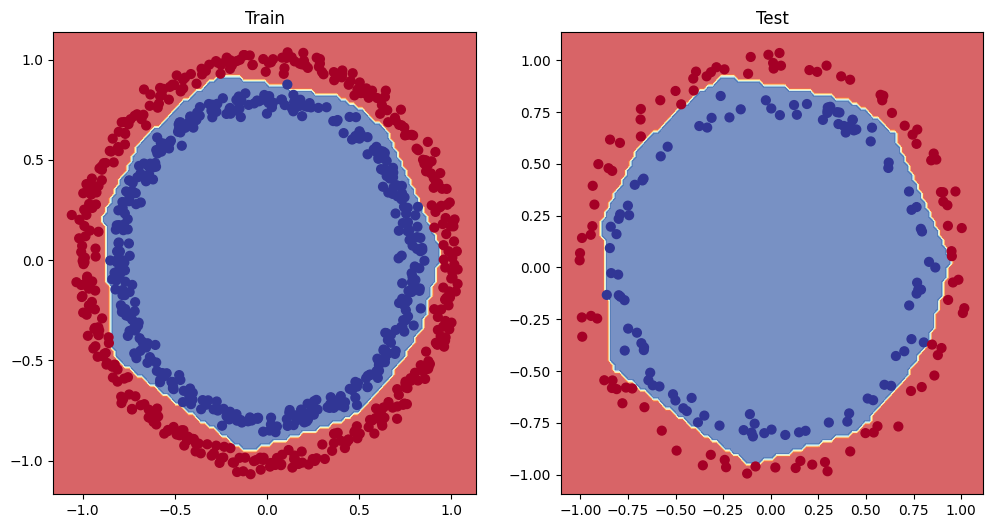

In [31]:
# Plot decision boundaries for training and test sets
from helper_functions import plot_decision_boundary


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)  # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)  # model_3 = has non-linearity